<a href="https://colab.research.google.com/github/sanghee0627/-/blob/main/epoch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/fox.zip 파일 선택

Saving fox.zip to fox.zip


In [ ]:
!unzip fox.zip -d fox/

Archive:  fox.zip
   creating: fox/fox/
  inflating: fox/fox/.DS_Store       
  inflating: fox/__MACOSX/fox/._.DS_Store  
   creating: fox/fox/train/
   creating: fox/fox/train/붉은여우/
  inflating: fox/fox/train/.DS_Store  
  inflating: fox/__MACOSX/fox/train/._.DS_Store  
   creating: fox/fox/train/북극여우/
  inflating: fox/fox/train/붉은여우/1080.jpeg  
  inflating: fox/__MACOSX/fox/train/붉은여우/._1080.jpeg  
  inflating: fox/fox/train/붉은여우/스크린샷 2023-05-30 오전 2.28.42.png  
  inflating: fox/__MACOSX/fox/train/붉은여우/._스크린샷 2023-05-30 오전 2.28.42.png  
  inflating: fox/fox/train/붉은여우/1096.jpeg  
  inflating: fox/__MACOSX/fox/train/붉은여우/._1096.jpeg  
  inflating: fox/fox/train/붉은여우/1079.jpeg  
  inflating: fox/__MACOSX/fox/train/붉은여우/._1079.jpeg  
  inflating: fox/fox/train/붉은여우/071859b6aefc21736c70894f9cf5bdf3.jpeg  
  inflating: fox/__MACOSX/fox/train/붉은여우/._071859b6aefc21736c70894f9cf5bdf3.jpeg  
  inflating:

In [ ]:
data_path = 'fox/fox/train'
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), #이미지 뒤집기
    transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

188


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
learning_rate = 0.001;#학습률조정
model = FashionCNN();
model.to(device)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


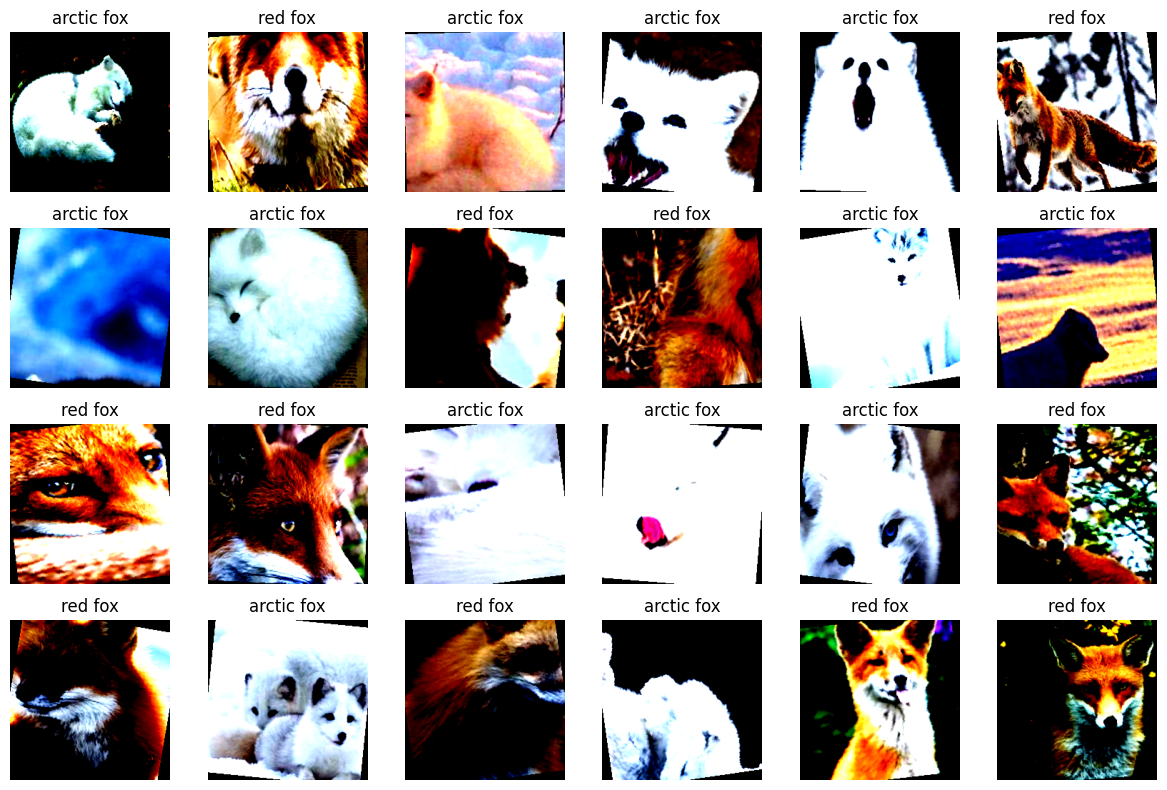

In [ ]:
samples, labels = next(iter(train_loader))
classes = {0:'arctic fox', 1:'red fox'}

fig, axes = plt.subplots(4, 6, figsize=(12, 8))

for i, axus in enumerate(axes.flatten()):
    image = np.transpose(samples[i].numpy(), (1, 2, 0))
    label = classes[labels[i].item()]

    axus.imshow(image)
    axus.set_title(label)
    axus.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=256*14*14, out_features=1024)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=5):
    since = time.time()
    best_acc = 0.0
    acc_history = []
    loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(dataloaders['train'].dataset)
        val_acc = val_corrects.double() / len(dataloaders['train'].dataset)

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

        acc_history.append(val_acc.item())
        loss_history.append(val_loss)

        scheduler.step()  # Update the learning rate

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

num_classes = 2  # Modify this according to your dataset
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
print(resnet18)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Learning rate scheduler

print(resnet18)

dataloaders = {
    'train': train_loader,  # Make sure train_loader is properly assigned
}

acc_history, loss_history = train_model(resnet18, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

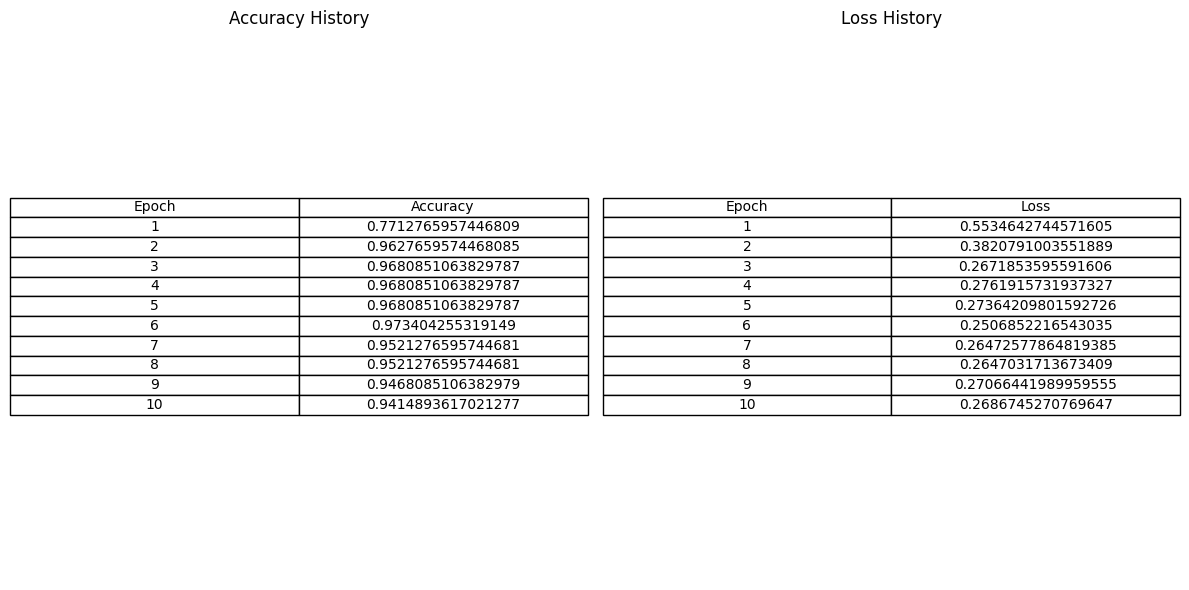

In [ ]:
# Your code to train the model and obtain acc_history and loss_history

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy table
ax_acc = axes[0]
ax_acc.axis('off')
table_data_acc = [['Epoch', 'Accuracy']] + [[i, acc] for i, acc in enumerate(acc_history, 1)]
ax_acc.table(cellText=table_data_acc, loc='center', cellLoc='center')
ax_acc.set_title("Accuracy History")

# Loss table
ax_loss = axes[1]
ax_loss.axis('off')
table_data_loss = [['Epoch', 'Loss']] + [[i, loss] for i, loss in enumerate(loss_history, 1)]
ax_loss.table(cellText=table_data_loss, loc='center', cellLoc='center')
ax_loss.set_title("Loss History")

plt.tight_layout()
plt.show()


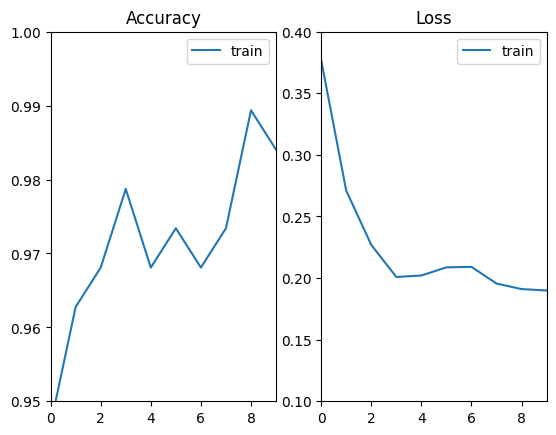

In [ ]:
plt.subplot(121)
plt.plot(acc_history, label="train")
#plt.plot(val_acc_hist, label="test")
plt.xlim([0, 9])
plt.ylim([0.95, 1.0])
plt.legend()
plt.title("Accuracy")

plt.subplot(122)
plt.plot(loss_history, label="train")
#plt.plot(train_loss_hist, label="test")
plt.xlim([0, 9])
plt.ylim([0.1, 0.4])
plt.legend()
plt.title("Loss")

plt.show()

In [ ]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['arctic fox', 'red fox']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert accuracy and loss history to 2-dimensional vectors using t-SNE
tsne_acc = TSNE(n_components=2, random_state=42).fit_transform(np.array(acc_history).reshape(-1, 1))
tsne_loss = TSNE(n_components=2, random_state=42).fit_transform(np.array(loss_history).reshape(-1, 1))

# Plot t-SNE visualization of accuracy and loss history
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy t-SNE plot
ax_acc = axes[0]
ax_acc.scatter(tsne_acc[:, 0], tsne_acc[:, 1])
ax_acc.set_title("Accuracy (t-SNE)")

# Loss t-SNE plot
ax_loss = axes[1]
ax_loss.scatter(tsne_loss[:, 0], tsne_loss[:, 1])
ax_loss.set_title("Loss (t-SNE)")

plt.tight_layout()
plt.show()
